In [1]:
pacman::p_load(ggplot2,ggpubr,phylotools,geiger,ggtreeExtra,
               phytools,phyloseq,ggtree,ape,grid,tidyr,wesanderson,data.table,
               ggnewscale,stringr,lubridate,ggridges,patchwork,ggstance,dendextend,tidyverse)

In [2]:
sam_with_meta_bact <- data.frame(fread(file.path("..","..","data","sam_with_meta_bact.csv")))
sam_with_meta <- data.frame(fread(file.path("..","..","data","sam_with_meta_euk.csv")))
data_tree_bact <- data.frame(fread(file.path("..","..","data","data_tree_bact.csv")))
data_tree_euk <- data.frame(fread(file.path("..","..","data","data_tree_euk.csv")))

sam_with_meta_bact_filt <- data.frame(fread(file.path("..","..","data","sam_with_meta_bact_filt.csv")))
sam_with_meta_filt <- data.frame(fread(file.path("..","..","data","sam_with_meta_euk_filt.csv")))

In [3]:
mendota_metadata = read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos", "2021-mendota-18S",
                                      "meta-lakes","meta-lakes-pipeline","data",
                                      "phytoplankton_madison_v2_24Feb2021.csv"),sep=",")
mendota_taxonomy = read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos", "2021-mendota-18S",
                                      "meta-lakes","meta-lakes-pipeline","data",
                                      "taxonomy_ntl_mendota.csv"),sep=",")


mendota_metadata = mendota_metadata %>%
    dplyr::mutate(Genus = vapply(strsplit(taxa_name," "), `[`, 1, FUN.VALUE=character(1))) %>%
    dplyr::mutate(Species = vapply(strsplit(taxa_name," "), `[`, 2, FUN.VALUE=character(1)))

In [4]:
create_for_plotting <- function(for_plotting) {
    for (row_curr in c(1:nrow(for_plotting))) {
        if (trimws(for_plotting$Phylum[row_curr]) == "Metazoa") {
            extra_slots = unlist(strsplit(for_plotting$AllOthers[row_curr],";"))
            if (length(extra_slots) == 11) {
                for_plotting$Phylum[row_curr] = trimws(extra_slots[1])
                for_plotting$Class[row_curr] = trimws(extra_slots[5])
                for_plotting$Order[row_curr] = trimws(extra_slots[9])
                for_plotting$Family[row_curr] = trimws(extra_slots[10])
                for_plotting$Genus[row_curr] = trimws(extra_slots[11])
            } else if (length(extra_slots == 7)) {
                for_plotting$Phylum[row_curr] = trimws(extra_slots[1])
                for_plotting$Class[row_curr] = trimws(extra_slots[3])
                for_plotting$Order[row_curr] = trimws(extra_slots[5])
                for_plotting$Family[row_curr] = trimws(extra_slots[6])
                for_plotting$Genus[row_curr] = trimws(extra_slots[7])
            }
        }
        if (trimws(for_plotting$Phylum[row_curr]) == "Opisthokonta") {
                for_plotting$Phylum[row_curr] = "Choanozoa"
                for_plotting$Class[row_curr] = "Ichthyosporea"
                for_plotting$Order[row_curr] = "Eccrinida"
                for_plotting$Family[row_curr] = "Piridae"
                for_plotting$Genus[row_curr] = "Pirum"
        }
    }
    for_plotting = for_plotting %>%
        dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                      Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")))
    return(for_plotting)
}
data_tree_bact$TipLabs = data_tree_bact$label
for (curr_ind in 1:nrow(data_tree_bact)) {
  curr_splitter = unlist(strsplit(as.character(data_tree_bact$TipLabs[curr_ind]),"\\|"))
  if (!is.null(curr_splitter)) {
      data_tree_bact$TipLabs[curr_ind] = unlist(strsplit(unlist(strsplit(curr_splitter[length(curr_splitter)],
                                                                         "\\."))[1],"SSU_"))[1]
  }
}


sam_with_meta_bact$X.rname = sapply(strsplit(as.character(vapply(strsplit(sam_with_meta_bact$X.rname,
                                                                                   "SSU_"), `[`, 1, 
                                    FUN.VALUE=character(1))), "\\|"), tail, 1)

for_plotting_bact = sam_with_meta_bact %>% dplyr::inner_join(data_tree_bact,
                                                             by = c("X.rname" = "TipLabs","Label"))%>% 
    dplyr::group_by(Label) %>%
    dplyr::mutate(ZScore = (TPM - mean(TPM)) / sd(TPM)) %>%
    dplyr::ungroup()

In [5]:
for_plotting = sam_with_meta %>% dplyr::inner_join(data_tree_euk, by = c("X.rname" = "label","Label"))

for (row_curr in c(1:nrow(for_plotting))) {
    if (trimws(for_plotting$Phylum[row_curr]) == "Metazoa") {
        extra_slots = unlist(strsplit(for_plotting$AllOthers[row_curr],";"))
        if (length(extra_slots) == 11) {
            for_plotting$Phylum[row_curr] = trimws(extra_slots[1])
            for_plotting$Class[row_curr] = trimws(extra_slots[5])
            for_plotting$Order[row_curr] = trimws(extra_slots[9])
            for_plotting$Family[row_curr] = trimws(extra_slots[10])
            for_plotting$Genus[row_curr] = trimws(extra_slots[11])
        } else if (length(extra_slots == 7)) {
            for_plotting$Phylum[row_curr] = trimws(extra_slots[1])
            for_plotting$Class[row_curr] = trimws(extra_slots[3])
            for_plotting$Order[row_curr] = trimws(extra_slots[5])
            for_plotting$Family[row_curr] = trimws(extra_slots[6])
            for_plotting$Genus[row_curr] = trimws(extra_slots[7])
        }
        print(for_plotting[row_curr,])
    }
    if (trimws(for_plotting$Phylum[row_curr]) == "Opisthokonta") {
            for_plotting$Phylum[row_curr] = "Choanozoa"
            for_plotting$Class[row_curr] = "Ichthyosporea"
            for_plotting$Order[row_curr] = "Eccrinida"
            for_plotting$Family[row_curr] = "Piridae"
            for_plotting$Genus[row_curr] = "Pirum"
    }
    
    if (trimws(for_plotting$Phylum[row_curr]) == "Cryptophyceae") {
        for_plotting$Genus[row_curr] = for_plotting$Family[row_curr]
        for_plotting$Family[row_curr] = for_plotting$Order[row_curr]
        for_plotting$Order[row_curr] = for_plotting$Class[row_curr]
        for_plotting$Class[row_curr] = for_plotting$Phylum[row_curr]
        for_plotting$Phylum[row_curr] = "Cryptophyta"
    }
    
    if (trimws(for_plotting$Order[row_curr]) == "Fragilariophyceae") {
            for_plotting$Class[row_curr] = for_plotting$Order[row_curr]
            for_plotting$Order[row_curr] = for_plotting$Species[row_curr]
            for_plotting$Family[row_curr] = ""
            for_plotting$Genus[row_curr] = ""
            for_plotting$Species[row_curr] = ""
    } else if (trimws(for_plotting$Class[row_curr]) == "Bacillariophyta") {
            for_plotting$Class[row_curr] = for_plotting$Order[row_curr]
            for_plotting$Order[row_curr] = for_plotting$Species[row_curr]
            for_plotting$Family[row_curr] = ""
            for_plotting$Genus[row_curr] = ""
            for_plotting$Species[row_curr] = ""
    }
}
curr_cm="RF01960"
for_plotting = for_plotting %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y"))) %>%
    dplyr::select(-Phylum,-Genus,-Family,-Class,-Order,-Species,-Domain) %>%
    dplyr::left_join(read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos",
                                        "2021-mendota-18S","refseq-DIAMOND", 
                                        "tree-builder", "2021-12-20_eukaryota", paste0("taxonomy_dict_",curr_cm,
                     ".csv"))),by=c("X.rname"="qseqid")) %>%
    dplyr::mutate(Order = dplyr::case_when(Order == "Coscinodiscophycidae" ~ "Aulacoseirales",
                                           TRUE ~ Order))%>% 
    dplyr::group_by(Label) %>%
    dplyr::mutate(ZScore = (TPM - mean(TPM)) / sd(TPM)) %>%
    dplyr::ungroup()

In [6]:
merged_mendota = mendota_metadata %>% dplyr::mutate(Genus = trimws(Genus)) %>%
                        dplyr::inner_join(mendota_taxonomy %>% 
                                                       dplyr::select(-Species,-Organism) %>%
                                                       dplyr::distinct() %>%
                                                       dplyr::mutate(Genus = trimws(Genus)),
                                                       by = c("Genus" = "Genus")) %>%
                dplyr::bind_rows(mendota_metadata %>%
                        dplyr::inner_join(mendota_taxonomy %>% 
                                                       dplyr::select(-Species,-Organism,-Genus) %>%
                                                       dplyr::distinct(),
                                                       by = c("Genus" = "Family")) %>%
                                dplyr::rename("Family"="Genus"))%>%
    dplyr::filter(!is.na(Domain))

In [7]:
phylum_z_score = merged_mendota %>% dplyr::group_by(Phylum,sampledate,year4) %>% 
    dplyr::summarize(cells_per_ml = sum(cells_per_ml, na.rm=TRUE)) %>%
    dplyr::ungroup() %>% dplyr::group_by(Phylum) %>%
    dplyr::mutate(ZScore = (cells_per_ml - mean(cells_per_ml,na.rm=TRUE)) / sd(cells_per_ml,na.rm=TRUE))

`summarise()` has
grouped output by
'Phylum',
'sampledate'. You
can override using
the `.groups`
argument.


In [81]:
check_corr <- function(mendota_merged, tymeflies, taxlevel, taxon_tf, taxon_md,within_year=FALSE,
                       return_frame=FALSE,pval=FALSE) {
    mendota_merged= mendota_merged[sapply(sapply(mendota_merged[taxlevel],trimws),
                                          function(x) x == taxon_md),] %>%
                    dplyr::group_by(.dots=as.symbol(taxlevel),sampledate) %>%
                    dplyr::summarize(cells_per_ml = sum(cells_per_ml,na.rm=TRUE))
    flush.console()
    tymeflies= tymeflies[sapply(sapply(tymeflies[taxlevel],trimws),
                                          function(x) x == taxon_tf),]%>%
                    dplyr::group_by(.dots=as.symbol(taxlevel),SampleDate) %>%
                    dplyr::summarize(TPM = sum(TPM,na.rm=TRUE))
    #flush.console()
                                
    mendota_merged$Week = as.Date(cut(as.POSIXct(mendota_merged$sampledate,format="%Y-%m-%d"), "week"))
    tymeflies$Week = as.Date(cut(as.POSIXct(tymeflies$SampleDate,format="%d%b%Y"), "week"))
    compare_frame = mendota_merged %>% dplyr::full_join(tymeflies %>% dplyr::select(-all_of(taxlevel)),
                                                         by = c("Week"))
    compare_frame$TPM = approx((compare_frame %>% dplyr::filter(!is.na(TPM)))$Week,
     (compare_frame %>% dplyr::filter(!is.na(TPM)))$TPM,
     compare_frame$Week,
     #(compare_frame %>% dplyr::filter(is.na(TPM)))$Week, 
                               method="linear")$y
                                
    compare_frame = compare_frame %>%
                    dplyr::mutate(Year = dplyr::case_when(!is.na(sampledate) ~ 
                                                          format(as.POSIXct(sampledate,
                                                                            format="%Y-%m-%d"), "%Y"),
                                                          TRUE ~ format(as.POSIXct(SampleDate,
                                                                                   format="%d%b%Y"), "%Y")))
                                
    compare_frame$cells_per_ml = approx((compare_frame %>% dplyr::filter(!is.na(cells_per_ml)))$Week,
     (compare_frame %>% dplyr::filter(!is.na(cells_per_ml)))$cells_per_ml,
     compare_frame$Week,
     #(compare_frame %>% dplyr::filter(is.na(cells_per_ml)))$Week,
                                        method="linear")$y      
    if (within_year) {
        compare_frame = compare_frame %>%
            dplyr::group_by(.dots=as.symbol(taxlevel),Year) %>%
            dplyr::mutate(cells_per_mlZScore = (cells_per_ml - mean(cells_per_ml,na.rm=TRUE)) / sd(cells_per_ml,na.rm=TRUE),
                          TPMZScore = (TPM - mean(TPM,na.rm=TRUE)) / sd(TPM,na.rm=TRUE))
    } else {       
        compare_frame = compare_frame %>%
            dplyr::group_by(.dots=as.symbol(taxlevel)) %>%
            dplyr::mutate(cells_per_mlZScore = (cells_per_ml - mean(cells_per_ml,na.rm=TRUE)) / sd(cells_per_ml,na.rm=TRUE),
                          TPMZScore = (TPM - mean(TPM,na.rm=TRUE)) / sd(TPM,na.rm=TRUE))
    }
    print(cor(compare_frame$cells_per_mlZScore, compare_frame$TPMZScore,
              method = c("pearson", "kendall", "spearman")))
    print(cor.test(compare_frame$cells_per_mlZScore, compare_frame$TPMZScore,
                   method=c("pearson", "kendall", "spearman")))
    if (return_frame){
        return(compare_frame)
    }
                                
    if (pval) {
        return(cor.test(compare_frame$cells_per_mlZScore, compare_frame$TPMZScore,
                   method=c("pearson")))#, "kendall", "spearman")))
    }
    return(cor(compare_frame$cells_per_mlZScore, compare_frame$TPMZScore,
               method = c("pearson"),#, "kendall", "spearman"),
               use = "complete.obs"))
}
                                
compare_plot <- function(curr_df,color_in="blue",label_in="Fragilariopsis") {   
    print(summary(lm(TPMZScore~cells_per_mlZScore,data=curr_df)))
    return(ggplot(curr_df) + geom_point(aes(x = cells_per_mlZScore, y = TPMZScore)) +
        geom_smooth(aes(x = cells_per_mlZScore, y = TPMZScore,color=color_in),method="lm")+
        geom_abline(aes(intercept=0,slope=1), linetype="dotted") +
        scale_color_manual(name = "", values = c(color_in), breaks = c(color_in)) +
        theme_bw(base_size = 16) + theme(legend.position="none") + 
        ggtitle(label_in) + 
        ylab("Metagenome Z-Score") + 
        xlab("NTL Z-Score"))
}

In [9]:
ntl_cyanos = ggplot(merged_mendota %>% dplyr::filter(Phylum == "Cyanobacteria")) + 
    geom_point(aes(x = as.Date(sampledate,format="%Y-%m-%d"), y = cells_per_ml,color="NTL"), 
               alpha=0.5,size=3)+ 
    geom_line(aes(x = as.Date(sampledate,format="%Y-%m-%d"), y = cells_per_ml,color="NTL"))+ 
    scale_color_manual(name="", values=c("turquoise","purple"),breaks=c("NTL","Metagenome")) + 
    theme_bw(base_size=12) + xlab("Date") + ylab("Z-Score") + facet_wrap(~Family,ncol=2)

In [10]:
mg_cyanos = ggplot(for_plotting_bact%>% dplyr::filter(Phylum == "Cyanobacteria")) +
    geom_point(aes(x = as.Date(SampleDate,format="%d%b%Y"), y = TPM,color="Metagenome"), 
               alpha=0.5,size=3) + facet_wrap(~Family,ncol=2) +theme_bw(base_size=12) + 
    geom_line(aes(x = as.Date(SampleDate,format="%d%b%Y"), y = TPM,color="Metagenome")) +
    scale_color_manual(name="", values=c("turquoise","purple"),breaks=c("NTL","Metagenome")) + 
    xlab("Date")

Warning message:
“Removed 180 rows containing missing values (geom_point).”
Warning message:
“Removed 6 row(s) containing missing values (geom_path).”
Warning message:
“Removed 180 rows containing missing values (geom_point).”
Warning message:
“Removed 6 row(s) containing missing values (geom_path).”


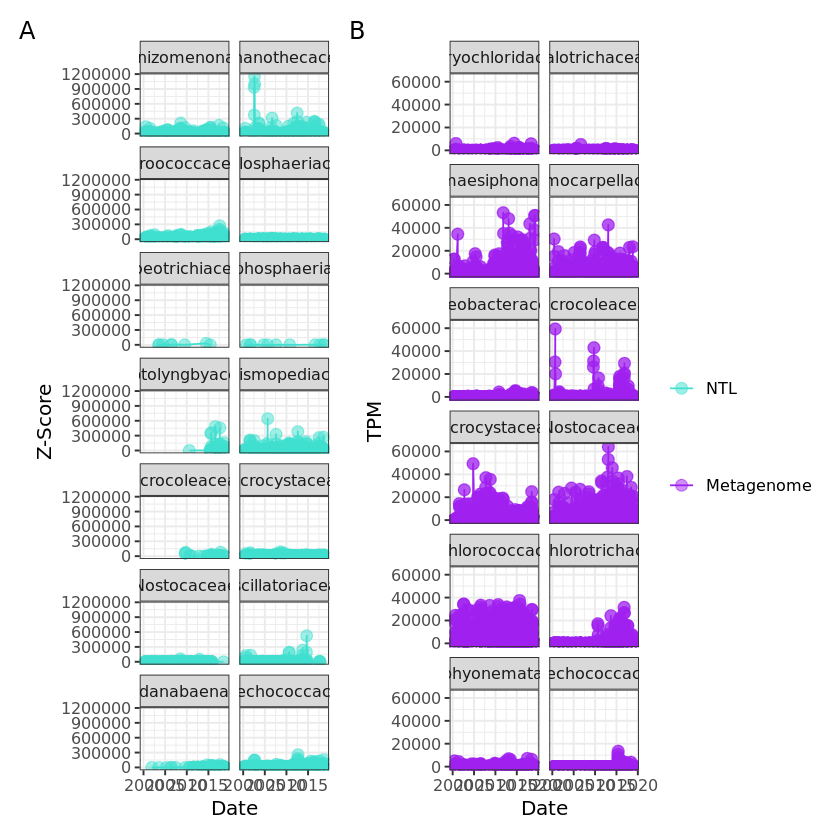

In [63]:
ntl_cyanos + mg_cyanos +
    plot_layout(guides = 'collect',widths=c(1,1))+ plot_annotation(tag_levels = 'A')
ggsave(file.path("..","..","figures","cyanobacteria_plot.png"),dpi=400,width=10,height=10,units="in")

In [82]:
all_corrs = data.frame()
curr_level="Family"
for (curr_fam in unique(for_plotting_bact$Family)) { 
    if (curr_fam %in% merged_mendota$Family) {
        curr_corr = check_corr(merged_mendota, for_plotting_bact, curr_level,
                               curr_fam, curr_fam, within_year=FALSE)
        all_corrs = all_corrs %>% 
            dplyr::bind_rows(data.frame("Family"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "Corr"=curr_corr))
    }
}

`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 8.1877, df = 242, p-value = 1.532e-14
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3613016 0.5586626
sample estimates:
      cor 
0.4657542 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 9.3262, df = 430, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3285440 0.4857258
sample estimates:
      cor 
0.4101762 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 7.0128, df = 368, p-value = 1.125e-11
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2501469 0.4302375
sample estimates:
      cor 
0.3433443 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = -2.6294, df = 485, p-value = 0.008825
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.20524554 -0.03001512
sample estimates:
       cor 
-0.1185533 



In [15]:
all_corrs_euk_order = data.frame()
curr_level="Order"
for (curr_fam in unique(for_plotting$Order)) { 
    if (curr_fam %in% merged_mendota$Order) {
        curr_corr = check_corr(merged_mendota, for_plotting, curr_level,
                               curr_fam, curr_fam, within_year=FALSE)
        all_corrs_euk_order = all_corrs_euk_order %>% 
            dplyr::bind_rows(data.frame("Order"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "Corr"=curr_corr))
    }
}

`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 3.0289, df = 485, p-value = 0.002586
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.04797732 0.22241250
sample estimates:
      cor 
0.1362508 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 7.5766, df = 369, p-value = 2.887e-13
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2753863 0.4518506
sample estimates:
      cor 
0.3669146 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 2.1383, df = 366, p-value = 0.03316
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.008947307 0.210912326
sample estimates:
      cor 
0.1110765 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 12.682, df = 161, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6206599 0.7762938
sample estimates:
      cor 
0.7069332 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 1.7471, df = 471, p-value = 0.08127
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.009990417  0.169179673
sample estimates:
       cor 
0.08024275 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 12.522, df = 207, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5717339 0.7274121
sample estimates:
      cor 
0.6565083 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = -2.1868, df = 473, p-value = 0.02925
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.18831937 -0.01016452
sample estimates:
       cor 
-0.1000437 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 0.8349, df = 378, p-value = 0.4043
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.05794885  0.14288817
sample estimates:
       cor 
0.04290308 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 18.149, df = 358, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6342566 0.7424740
sample estimates:
      cor 
0.6922368 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 2.3545, df = 317, p-value = 0.01916
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.02159674 0.23749083
sample estimates:
      cor 
0.1310978 



In [140]:
all_corrs_euk = data.frame()
curr_level="Family"
for (curr_fam in unique(c(for_plotting$Family,(merged_mendota%>%dplyr::filter(Domain=="Eukaryota"))$Family))) { 
    
    if (!(curr_fam %in% for_plotting$Family)) {
        all_corrs_euk = all_corrs_euk %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Not in MG",
                                        "Corr"=NA,
                                        "PValue"=NA))
    } else if (!(curr_fam %in% merged_mendota$Family)) {
        all_corrs_euk = all_corrs_euk %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Not in NTL",
                                        "Corr"=NA,
                                        "PValue"=NA))
    } else {
        curr_corr = check_corr(merged_mendota, for_plotting, curr_level,
                               curr_fam, curr_fam, within_year=FALSE)
        curr_corr_pval = check_corr(merged_mendota, for_plotting, curr_level,
                               curr_fam, curr_fam, within_year=FALSE,pval=TRUE)
        all_corrs_euk = all_corrs_euk %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Found in both",
                                        "Corr"=curr_corr,
                                        "PValue"=curr_corr_pval$p.value))
    } 
}
curr_level="Order"
for (curr_fam in unique(c(for_plotting$Order,(merged_mendota%>%dplyr::filter(Domain=="Eukaryota"))$Order))) { 
    
    if (!(curr_fam %in% for_plotting$Order)) {
        all_corrs_euk = all_corrs_euk %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Not in MG",
                                        "Corr"=NA,
                                        "PValue"=NA))
    } else if (!(curr_fam %in% merged_mendota$Order)) {
        all_corrs_euk = all_corrs_euk %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Not in NTL",
                                        "Corr"=NA,
                                        "PValue"=NA))
    } else {
        curr_corr = check_corr(merged_mendota, for_plotting, curr_level,
                               curr_fam, curr_fam, within_year=FALSE)
        curr_corr_pval = check_corr(merged_mendota, for_plotting, curr_level,
                               curr_fam, curr_fam, within_year=FALSE,pval=TRUE)
        all_corrs_euk = all_corrs_euk %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Found in both",
                                        "Corr"=curr_corr,
                                        "PValue"=curr_corr_pval$p.value))
    } 
}
curr_level="Class"
for (curr_fam in unique(c(for_plotting$Class,(merged_mendota%>%dplyr::filter(Domain=="Eukaryota"))$Class))) { 
    
    if (!(curr_fam %in% for_plotting$Class)) {
        all_corrs_euk = all_corrs_euk %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Not in MG",
                                        "Corr"=NA,
                                        "PValue"=NA))
    } else if (!(curr_fam %in% merged_mendota$Class)) {
        all_corrs_euk = all_corrs_euk %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Not in NTL",
                                        "Corr"=NA,
                                        "PValue"=NA))
    } else {
        curr_corr = check_corr(merged_mendota, for_plotting, curr_level,
                               curr_fam, curr_fam, within_year=FALSE)
        curr_corr_pval = check_corr(merged_mendota, for_plotting, curr_level,
                               curr_fam, curr_fam, within_year=FALSE,pval=TRUE)
        all_corrs_euk = all_corrs_euk %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Found in both",
                                        "Corr"=curr_corr,
                                        "PValue"=curr_corr_pval$p.value))
    } 
}
curr_level="Phylum"
for (curr_fam in unique(c(for_plotting$Phylum,(merged_mendota%>%dplyr::filter(Domain=="Eukaryota"))$Phylum))) { 
    
    if (!(curr_fam %in% for_plotting$Phylum) | (curr_fam == "Euglenozoa")) {
        all_corrs_euk = all_corrs_euk %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Not in MG",
                                        "Corr"=NA,
                                        "PValue"=NA))
    } else if (!(curr_fam %in% merged_mendota$Phylum)) {
        all_corrs_euk = all_corrs_euk %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Not in NTL",
                                        "Corr"=NA,
                                        "PValue"=NA))
    } else {
        curr_corr = check_corr(merged_mendota, for_plotting, curr_level,
                               curr_fam, curr_fam, within_year=FALSE)
        curr_corr_pval = check_corr(merged_mendota, for_plotting, curr_level,
                               curr_fam, curr_fam, within_year=FALSE,pval=TRUE)
        all_corrs_euk = all_corrs_euk %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Found in both",
                                        "Corr"=curr_corr,
                                        "PValue"=curr_corr_pval$p.value))
    } 
}



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 6.7326, df = 421, p-value = 5.477e-11
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2230561 0.3953647
sample estimates:
      cor 
0.3117715 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 6.7326, df = 421, p-value = 5.477e-11
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2230561 0.3953647
sample estimates:
      cor 
0.3117715 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 12.682, df = 161, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6206599 0.7762938
sample estimates:
      cor 
0.7069332 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 12.682, df = 161, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6206599 0.7762938
sample estimates:
      cor 
0.7069332 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 12.522, df = 207, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5717339 0.7274121
sample estimates:
      cor 
0.6565083 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 12.522, df = 207, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5717339 0.7274121
sample estimates:
      cor 
0.6565083 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 10.32, df = 442, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3624520 0.5126877
sample estimates:
      cor 
0.4406502 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 10.32, df = 442, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3624520 0.5126877
sample estimates:
      cor 
0.4406502 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 5.3833, df = 283, p-value = 1.537e-07
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1955182 0.4065713
sample estimates:
      cor 
0.3047817 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 5.3833, df = 283, p-value = 1.537e-07
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1955182 0.4065713
sample estimates:
      cor 
0.3047817 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = -0.49471, df = 293, p-value = 0.6212
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1426165  0.0855911
sample estimates:
        cor 
-0.02888914 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = -0.49471, df = 293, p-value = 0.6212
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1426165  0.0855911
sample estimates:
        cor 
-0.02888914 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 18.149, df = 358, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6342566 0.7424740
sample estimates:
      cor 
0.6922368 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 18.149, df = 358, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6342566 0.7424740
sample estimates:
      cor 
0.6922368 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = -0.80285, df = 485, p-value = 0.4225
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.12488128  0.05259336
sample estimates:
       cor 
-0.0364312 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = -0.80285, df = 485, p-value = 0.4225
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.12488128  0.05259336
sample estimates:
       cor 
-0.0364312 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 2.4754, df = 466, p-value = 0.01367
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.02352307 0.20247280
sample estimates:
      cor 
0.1139219 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 2.4754, df = 466, p-value = 0.01367
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.02352307 0.20247280
sample estimates:
      cor 
0.1139219 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 3.0289, df = 485, p-value = 0.002586
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.04797732 0.22241250
sample estimates:
      cor 
0.1362508 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 3.0289, df = 485, p-value = 0.002586
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.04797732 0.22241250
sample estimates:
      cor 
0.1362508 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 7.5766, df = 369, p-value = 2.887e-13
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2753863 0.4518506
sample estimates:
      cor 
0.3669146 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 7.5766, df = 369, p-value = 2.887e-13
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2753863 0.4518506
sample estimates:
      cor 
0.3669146 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 2.1383, df = 366, p-value = 0.03316
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.008947307 0.210912326
sample estimates:
      cor 
0.1110765 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 2.1383, df = 366, p-value = 0.03316
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.008947307 0.210912326
sample estimates:
      cor 
0.1110765 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 12.682, df = 161, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6206599 0.7762938
sample estimates:
      cor 
0.7069332 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 12.682, df = 161, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6206599 0.7762938
sample estimates:
      cor 
0.7069332 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 1.7471, df = 471, p-value = 0.08127
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.009990417  0.169179673
sample estimates:
       cor 
0.08024275 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 1.7471, df = 471, p-value = 0.08127
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.009990417  0.169179673
sample estimates:
       cor 
0.08024275 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 12.522, df = 207, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5717339 0.7274121
sample estimates:
      cor 
0.6565083 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 12.522, df = 207, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5717339 0.7274121
sample estimates:
      cor 
0.6565083 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = -2.1868, df = 473, p-value = 0.02925
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.18831937 -0.01016452
sample estimates:
       cor 
-0.1000437 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = -2.1868, df = 473, p-value = 0.02925
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.18831937 -0.01016452
sample estimates:
       cor 
-0.1000437 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 0.8349, df = 378, p-value = 0.4043
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.05794885  0.14288817
sample estimates:
       cor 
0.04290308 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 0.8349, df = 378, p-value = 0.4043
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.05794885  0.14288817
sample estimates:
       cor 
0.04290308 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 18.149, df = 358, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6342566 0.7424740
sample estimates:
      cor 
0.6922368 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 18.149, df = 358, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6342566 0.7424740
sample estimates:
      cor 
0.6922368 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 2.3545, df = 317, p-value = 0.01916
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.02159674 0.23749083
sample estimates:
      cor 
0.1310978 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 2.3545, df = 317, p-value = 0.01916
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.02159674 0.23749083
sample estimates:
      cor 
0.1310978 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 1.5528, df = 488, p-value = 0.1211
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.01857776  0.15772129
sample estimates:
       cor 
0.07011929 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 1.5528, df = 488, p-value = 0.1211
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.01857776  0.15772129
sample estimates:
       cor 
0.07011929 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 5.1059, df = 370, p-value = 5.28e-07
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1590274 0.3491294
sample estimates:
      cor 
0.2565579 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 5.1059, df = 370, p-value = 5.28e-07
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1590274 0.3491294
sample estimates:
      cor 
0.2565579 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 2.6166, df = 372, p-value = 0.009242
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.0334840 0.2326687
sample estimates:
     cor 
0.134434 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 2.6166, df = 372, p-value = 0.009242
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.0334840 0.2326687
sample estimates:
     cor 
0.134434 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 0.058083, df = 488, p-value = 0.9537
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.0859724  0.0911897
sample estimates:
        cor 
0.002629284 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 0.058083, df = 488, p-value = 0.9537
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.0859724  0.0911897
sample estimates:
        cor 
0.002629284 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 0.90885, df = 386, p-value = 0.364
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.05359509  0.14510016
sample estimates:
       cor 
0.04620959 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 0.90885, df = 386, p-value = 0.364
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.05359509  0.14510016
sample estimates:
       cor 
0.04620959 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 1.5528, df = 488, p-value = 0.1211
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.01857776  0.15772129
sample estimates:
       cor 
0.07011929 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 1.5528, df = 488, p-value = 0.1211
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.01857776  0.15772129
sample estimates:
       cor 
0.07011929 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 7.4185, df = 465, p-value = 5.669e-13
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2417092 0.4041228
sample estimates:
      cor 
0.3253131 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 7.4185, df = 465, p-value = 5.669e-13
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2417092 0.4041228
sample estimates:
      cor 
0.3253131 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 1.1923, df = 488, p-value = 0.2337
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.03485231  0.14180042
sample estimates:
       cor 
0.05389574 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 1.1923, df = 488, p-value = 0.2337
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.03485231  0.14180042
sample estimates:
       cor 
0.05389574 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 16.766, df = 426, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5697607 0.6843832
sample estimates:
     cor 
0.630497 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 16.766, df = 426, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5697607 0.6843832
sample estimates:
     cor 
0.630497 



In [141]:
write.csv(all_corrs_euk %>% 
    dplyr::filter(State == "Found in both") %>%
    dplyr::arrange(factor(TaxLevel,levels=c("Phylum","Class","Order","Family")),PValue),
          "../../data/ntl_csv_output.csv")

In [142]:
num_recovered = ggplot(all_corrs_euk %>% dplyr::group_by(State,TaxLevel) %>%
        dplyr::tally()) + geom_bar(aes(x=State,
                                       y=n,
                                       fill=factor(TaxLevel,levels=c("Phylum","Class",
                                                                     "Order","Family"))),
                                   stat="identity",position="dodge") + 
    theme_bw(base_size=16) + ylab("Number of taxa") + theme(axis.title.x=element_blank()) + 
    scale_fill_manual(values=c("turquoise","maroon","pink","orange"),name="Tax Level")

In [143]:
max(all_corrs_euk$Corr,na.rm=TRUE)

[1] 0.7069332

Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”


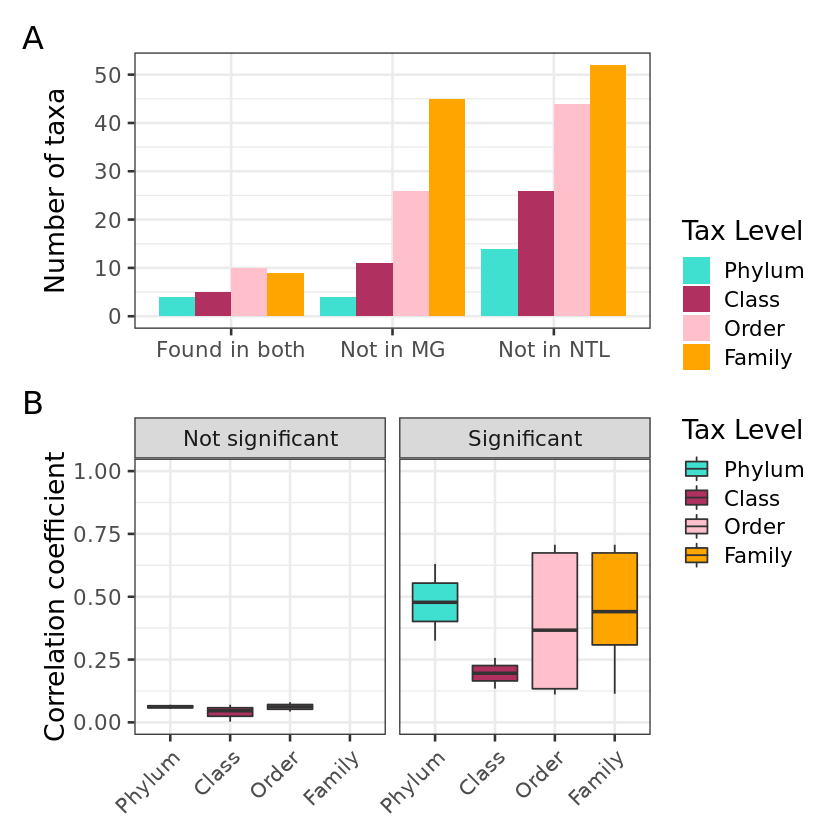

In [144]:
average_corr = ggplot(all_corrs_euk %>%
       dplyr::mutate(IsSignificant = dplyr::case_when(PValue < 0.05 ~ "Significant",
                                                      PValue > 0.05 ~ "Not significant",
                                                      TRUE ~"Missing")) %>%
       dplyr::filter(IsSignificant != "Missing")) + 
    geom_boxplot(aes(x=factor(TaxLevel,levels=c("Phylum","Class",
                                                                     "Order","Family")),
                                       y=Corr,
                                       fill=factor(TaxLevel,levels=c("Phylum","Class",
                                                                     "Order","Family")))) + 
    theme_bw(base_size=16) + ylab("Correlation coefficient") + theme(axis.title.x=element_blank()) + 
    scale_fill_manual(values=c("turquoise","maroon","pink","orange"),name="Tax Level") + ylim(c(0,1)) +
    facet_wrap(~IsSignificant)+
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
num_recovered / average_corr+ 
    plot_layout(guides = 'collect')+ plot_annotation(tag_levels = 'A')
ggsave("../../figures/ntl_summary.png",width=10,height=10,units="in")

In [145]:
all_corrs_bact = data.frame()
curr_level="Family"
for (curr_fam in unique(c(for_plotting_bact$Family,(merged_mendota%>%dplyr::filter(Domain=="Bacteria"))$Family))) { 
    if (!(curr_fam %in% for_plotting_bact$Family)) {
        all_corrs_bact = all_corrs_bact %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Not in MG",
                                        "Corr"=NA,
                                        "PValue"=NA))
    } else if (!(curr_fam %in% merged_mendota$Family)) {
        all_corrs_bact = all_corrs_bact %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Not in NTL",
                                        "Corr"=NA,
                                        "PValue"=NA))
    } else {
        curr_corr = check_corr(merged_mendota, for_plotting_bact, curr_level,
                               curr_fam, curr_fam, within_year=FALSE)
        curr_corr_pval = check_corr(merged_mendota, for_plotting_bact, curr_level,
                               curr_fam, curr_fam, within_year=FALSE,pval=TRUE)
        all_corrs_bact = all_corrs_bact %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Found in both",
                                        "Corr"=curr_corr,
                                        "PValue"=curr_corr_pval$p.value))
    } 
}
curr_level="Order"
for (curr_fam in unique(c(for_plotting_bact$Order,(merged_mendota%>%dplyr::filter(Domain=="Bacteria"))$Order))) { 
    
    if (!(curr_fam %in% for_plotting_bact$Order)) {
        all_corrs_bact = all_corrs_bact %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Not in MG",
                                        "Corr"=NA,
                                        "PValue"=NA))
    } else if (!(curr_fam %in% merged_mendota$Order)) {
        all_corrs_bact = all_corrs_bact %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Not in NTL",
                                        "Corr"=NA,
                                        "PValue"=NA))
    } else {
        curr_corr = check_corr(merged_mendota, for_plotting_bact, curr_level,
                               curr_fam, curr_fam, within_year=FALSE)
        curr_corr_pval = check_corr(merged_mendota, for_plotting_bact, curr_level,
                               curr_fam, curr_fam, within_year=FALSE,pval=TRUE)
        all_corrs_bact = all_corrs_bact %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Found in both",
                                        "Corr"=curr_corr,
                                        "PValue"=curr_corr_pval$p.value))
    } 
}
curr_level="Class"
for (curr_fam in unique(c(for_plotting_bact$Class,(merged_mendota%>%dplyr::filter(Domain=="Bacteria"))$Class))) { 
    
    if (!(curr_fam %in% for_plotting_bact$Class)) {
        all_corrs_bact = all_corrs_bact %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Not in MG",
                                        "Corr"=NA,
                                        "PValue"=NA))
    } else if (!(curr_fam %in% merged_mendota$Class)) {
        all_corrs_bact = all_corrs_bact %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Not in NTL",
                                        "Corr"=NA,
                                        "PValue"=NA))
    } else {
        curr_corr = check_corr(merged_mendota, for_plotting_bact, curr_level,
                               curr_fam, curr_fam, within_year=FALSE)
        curr_corr_pval = check_corr(merged_mendota, for_plotting_bact, curr_level,
                               curr_fam, curr_fam, within_year=FALSE,pval=TRUE)
        all_corrs_bact = all_corrs_bact %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Found in both",
                                        "Corr"=curr_corr,
                                        "PValue"=curr_corr_pval$p.value))
    } 
}
curr_level="Phylum"
for (curr_fam in unique(c(for_plotting_bact$Phylum,(merged_mendota%>%dplyr::filter(Domain=="Bacteria"))$Phylum))) { 
    
    if (!(curr_fam %in% for_plotting_bact$Phylum) | (curr_fam == "Euglenozoa")) {
        all_corrs_bact = all_corrs_bact %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Not in MG",
                                        "Corr"=NA,
                                        "PValue"=NA))
    } else if (!(curr_fam %in% merged_mendota$Phylum)) {
        all_corrs_bact = all_corrs_bact %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Not in NTL",
                                        "Corr"=NA,
                                        "PValue"=NA))
    } else {
        curr_corr = check_corr(merged_mendota, for_plotting_bact, curr_level,
                               curr_fam, curr_fam, within_year=FALSE)
        curr_corr_pval = check_corr(merged_mendota, for_plotting_bact, curr_level,
                               curr_fam, curr_fam, within_year=FALSE,pval=TRUE)
        all_corrs_bact = all_corrs_bact %>% 
            dplyr::bind_rows(data.frame("Taxon"=curr_fam,
                                        "TaxLevel"=curr_level,
                                        "State"="Found in both",
                                        "Corr"=curr_corr,
                                        "PValue"=curr_corr_pval$p.value))
    } 
}



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 8.1877, df = 242, p-value = 1.532e-14
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3613016 0.5586626
sample estimates:
      cor 
0.4657542 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 8.1877, df = 242, p-value = 1.532e-14
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3613016 0.5586626
sample estimates:
      cor 
0.4657542 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 9.3262, df = 430, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3285440 0.4857258
sample estimates:
      cor 
0.4101762 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 9.3262, df = 430, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3285440 0.4857258
sample estimates:
      cor 
0.4101762 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 7.0128, df = 368, p-value = 1.125e-11
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2501469 0.4302375
sample estimates:
      cor 
0.3433443 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 7.0128, df = 368, p-value = 1.125e-11
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2501469 0.4302375
sample estimates:
      cor 
0.3433443 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = -2.6294, df = 485, p-value = 0.008825
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.20524554 -0.03001512
sample estimates:
       cor 
-0.1185533 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = -2.6294, df = 485, p-value = 0.008825
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.20524554 -0.03001512
sample estimates:
       cor 
-0.1185533 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 2.6961, df = 408, p-value = 0.007305
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.03591883 0.22625409
sample estimates:
      cor 
0.1323059 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 2.6961, df = 408, p-value = 0.007305
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.03591883 0.22625409
sample estimates:
      cor 
0.1323059 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 15.172, df = 490, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5020413 0.6226350
sample estimates:
      cor 
0.5653516 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 15.172, df = 490, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5020413 0.6226350
sample estimates:
      cor 
0.5653516 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 6.738, df = 125, p-value = 5.258e-10
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3757468 0.6334264
sample estimates:
      cor 
0.5161725 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 6.738, df = 125, p-value = 5.258e-10
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3757468 0.6334264
sample estimates:
      cor 
0.5161725 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 10.791, df = 472, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3695949 0.5143117
sample estimates:
      cor 
0.4448524 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 10.791, df = 472, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3695949 0.5143117
sample estimates:
      cor 
0.4448524 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 1.8867, df = 490, p-value = 0.05979
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.003501307  0.172035945
sample estimates:
       cor 
0.08492625 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 1.8867, df = 490, p-value = 0.05979
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.003501307  0.172035945
sample estimates:
       cor 
0.08492625 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 9.4777, df = 490, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3162001 0.4657934
sample estimates:
      cor 
0.3935993 



`summarise()` has
grouped output by
'sampledate'. You
can override using
the `.groups`
argument.
`summarise()` has
grouped output by
'SampleDate'. You
can override using
the `.groups`
argument.
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


[1] NA

	Pearson's product-moment correlation

data:  compare_frame$cells_per_mlZScore and compare_frame$TPMZScore
t = 9.4777, df = 490, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3162001 0.4657934
sample estimates:
      cor 
0.3935993 



Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”


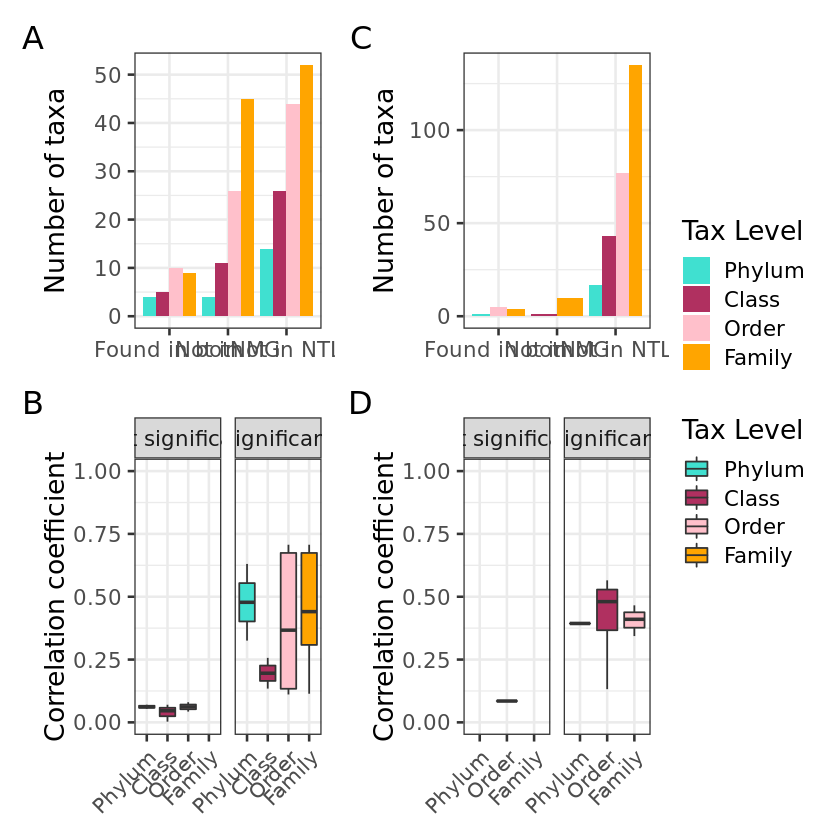

In [146]:
num_recovered_bact = ggplot(all_corrs_bact %>% dplyr::group_by(State,TaxLevel) %>%
        dplyr::tally()) + geom_bar(aes(x=State,
                                       y=n,
                                       fill=factor(TaxLevel,levels=c("Phylum","Class",
                                                                     "Order","Family"))),
                                   stat="identity",position="dodge") + 
    theme_bw(base_size=16) + ylab("Number of taxa") + theme(axis.title.x=element_blank()) + 
    scale_fill_manual(values=c("turquoise","maroon","pink","orange"),name="Tax Level")

average_corr_bact = ggplot(all_corrs_bact %>%
       dplyr::mutate(IsSignificant = dplyr::case_when(PValue < 0.05 ~ "Significant",
                                                      PValue > 0.05 ~ "Not significant",
                                                      TRUE ~"Missing")) %>%
       dplyr::filter(IsSignificant != "Missing")) + 
    geom_boxplot(aes(x=factor(TaxLevel,levels=c("Phylum","Class",
                                                                     "Order","Family")),
                                       y=Corr,
                                       fill=factor(TaxLevel,levels=c("Phylum","Class",
                                                                     "Order","Family")))) + 
    theme_bw(base_size=16) + ylab("Correlation coefficient") + theme(axis.title.x=element_blank()) + 
    scale_fill_manual(values=c("turquoise","maroon","pink","orange"),name="Tax Level") + ylim(c(0,1)) +
    facet_wrap(~IsSignificant)+
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
((num_recovered / average_corr) | (num_recovered_bact / average_corr_bact + theme(legend.position="none")))+ 
    plot_layout(guides = 'collect')+ plot_annotation(tag_levels = 'A')
ggsave("../../figures/ntl_summary_bact.png",width=15,height=10,units="in")

In [149]:
write.csv(all_corrs_euk %>% 
          dplyr::mutate(Domain="Eukaryota") %>%
          dplyr::bind_rows(all_corrs_bact %>% dplyr::mutate(Domain="Bacteria")) %>% 
    dplyr::filter(State == "Found in both") %>%
    dplyr::arrange(Domain,factor(TaxLevel,levels=c("Phylum","Class","Order","Family")),PValue),
          "../../data/ntl_csv_output_both.csv")

In [139]:
unique(merged_mendota$Order)
unique(for_plotting_bact$Order)

[1] "Stephanodiscales"                    
 [2] "Chromulinales"                       
 [3] "Ochromonadales"                      
 [4] "Sphaeropleales"                      
 [5] "Monomastigales"                      
 [6] "Cryptomonodales"                     
 [7] "Pyrenomonadales"                     
 [8] "Nostocales"                          
 [9] "Synechococcales"                     
[10] "Chroococcales"                       
[11] "Oscillatoriales"                     
[12] "Chlamydomonadales"                   
[13] "Cocconeidales"                       
[14] "Bacillariales"                       
[15] "Fragilariales"                       
[16] "Synurales"                           
[17] "Naviculales"                         
[18] "Isochrysidales"                      
[19] "Chlorellales"                        
[20] "Peridiniales"                        
[21] "Tabellariales"                       
[22] "Gymnodiniales"                       
[23] "Aulacoseirales"                      
[24] "Mastogloiales"                       
[25] "Ulotrichales"                        
[26] "Desmidiales"                         
[27] "Cymbellales"                         
[28] "Trebouxiales"                        
[29] "Rhizosoleniales"                     
[30] "Euglenida"                           
[31] "Trebouxiophyceae ordo incertae sedis"
[32] "Melosirales"                         
[33] "Pedinomonadales"                     
[34] "Nephroselmidales"                    
[35] "Mediophyceae"                        
[36] "Surirellales"                        
[37] "Prasiolales"                         
[38] "Prymnesiales"                        
[39] "Gonyaulacales"                       
[40] "Pseudanabaenales"                    
[41] "Coscinodiscales"

[1] "Bacillales"                         "Spirochaetales"                    
 [3] "Verrucomicrobiales"                 "Chthoniobacterales"                
 [5] "Opitutales"                         "Entomoplasmatales"                 
 [7] "Xanthomonadales"                    "Gaiellales"                        
 [9] "Solirubrobacterales"                "Aeromonadales"                     
[11] "Burkholderiales"                    "Nitrosomonadales"                  
[13] "Myxococcales"                       "Planctomycetales"                  
[15] "Bacteriovoracales"                  "Rhodocyclales"                     
[17] "Moraxellales"                       "Pseudomonadales"                   
[19] "Methylococcales"                    "Desulfuromonadales"                
[21] "Nevskiales"                         "Neisseriales"                      
[23] "Rickettsiales"                      "Gemmatales"                        
[25] "Gammaproteobacteria incertae sedis" "Flavobacteriales"                  
[27] "Terrimicrobiales"                   "Chitinophagales"                   
[29] "Silvanigrellales"                   "Isosphaerales"                     
[31] "Verrucomicrobia incertae sedis"     "Saprospirales"                     
[33] "Sphingobacteriales"                 "Acidimicrobiales"                  
[35] "Pirellulales"                       "Acidothermales"                    
[37] "Chromatiales"                       "Gemmatimonadales"                  
[39] "Bacteroidales"                      "Marinilabiliales"                  
[41] "Cytophagales"                       "Micrococcales"                     
[43] "Sporichthyales"                     "Geodermatophilales"                
[45] "Corynebacteriales"                  "Oscillatoriales"                   
[47] "Armatimonadales"                    "Rhodospirillales"                  
[49] "Caulobacterales"                    "Eubacteriales"                     
[51] "Holosporales"                       "Hyphomicrobiales"                  
[53] "Synechococcales"                    "Ignavibacteriales"                 
[55] "Phycisphaerales"                    "Gloeobacterales"                   
[57] "Pleurocapsales"                     "Pseudanabaenales"                  
[59] "Nostocales"                         "Chroococcales"                     
[61] "Sphingomonadales"                   "Pelagibacterales"                  
[63] "Micropepsales"                      "Rhodobacterales"                   
[65] "Chloroflexales"                     "Hyphomonadales"                    
[67] "Desulfobacterales"                  "Streptomycetales"                  
[69] "Vampirovibrionales"                 "Kiritimatiellales"                 
[71] "Parachlamydiales"                   "Vicinamibacterales"                
[73] "Cellvibrionales"                    "Erysipelotrichales"                
[75] "Blastocatellales"                   "Bdellovibrionales"                 
[77] "Campylobacterales"                  "Fimbriimonadales"                  
[79] "Caldilineales"                      "Bryobacterales"                    
[81] "Chlorobiales"                       "Anaerolineales"

In [107]:
sort(unique(all_corrs_euk %>% dplyr::filter((State == "Not in MG") & (TaxLevel == "Phylum")))$Taxon)
sort(unique(all_corrs_euk %>% dplyr::filter((State == "Not in NTL")& (TaxLevel == "Phylum")))$Taxon)

[1] "Alveolata"       "Apicomplexa"     "Arthropoda"      "Ascomycota"     
 [5] "Bigyra"          "Cercozoa"        "Chytridiomycota" "Ciliophora"     
 [9] "Endomyxa"        "Mollusca"        "Oomycota"        "Opisthokonta"   
[13] "Rotifera"        "Stramenopiles"

[1] "Charophyta"    "Chrysophyta"   "Cyanobacteria" "Euglenozoa"   
[5] "Myzozoa"

In [43]:
sort(unique(all_corrs_euk %>% dplyr::filter(State == "Not in NTL"))$Family)

[1] "Achnanthaceae"                       
 [2] "Actinochloridaceae"                  
 [3] "Aphanizomenonaceae"                  
 [4] "Aphanothecaceae"                     
 [5] "Aulacoseirales"                      
 [6] "Bacillariaceae"                      
 [7] "Botryococcaceae"                     
 [8] "Characiaceae"                        
 [9] "Chlorellaceae"                       
[10] "Chlorococcaceae"                     
[11] "Chroococcaceae"                      
[12] "Closteriaceae"                       
[13] "Coccomyxaceae"                       
[14] "Cocconeidaceae"                      
[15] "Coelosphaeriaceae"                   
[16] "Desmidiaceae"                        
[17] "Dinobryaceae"                        
[18] "Entomoneidaceae"                     
[19] "Euglenidae"                          
[20] "Gloeotrichiaceae"                    
[21] "Gomphonemataceae"                    
[22] "Gomphosphaeriaceae"                  
[23] "Gymnodiniaceae"                      
[24] "Hemidiscaceae"                       
[25] "Hydrodictyaceae"                     
[26] "Isochrysidaceae"                     
[27] "Leptolyngbyaceae"                    
[28] "Mallomonadaceae"                     
[29] "Melosiraceae"                        
[30] "Merismopediaceae"                    
[31] "Microcoleaceae"                      
[32] "Microcystaceae"                      
[33] "Monomastigaceae"                     
[34] "Naviculaceae"                        
[35] "Neochloridaceae"                     
[36] "Nephroselmidaceae"                   
[37] "Nostocaceae"                         
[38] "Ochromonadaceae"                     
[39] "Oocystaceae"                         
[40] "Oscillatoriaceae"                    
[41] "Pedinomonadaceae"                    
[42] "Peridiniaceae"                       
[43] "Phacotaceae"                         
[44] "Pseudanabaenaceae"                   
[45] "Radiococcaceae"                      
[46] "Rhizosoleniaceae"                    
[47] "Rhoicospheniaceae"                   
[48] "Scenedesmaceae"                      
[49] "Schroederiaceae"                     
[50] "Selenastraceae"                      
[51] "Sphaerocystidaceae"                  
[52] "Stichococcaceae"                     
[53] "Synechococcaceae"                    
[54] "Synuraceae"                          
[55] "Tabellariaceae"                      
[56] "Tetrasporaceae"                      
[57] "Thalassiosirales"                    
[58] "Trebouxiophyceae ordo incertae sedis"
[59] "Ulotrichaceae"

In [44]:
sort(unique(all_corrs_euk %>% dplyr::filter(State == "Not in MG"))$Family)

[1] ""                          "Acinetidae"               
 [3] "Alphamonaceae"             "Aulacoseiraceae"          
 [5] "Bicosoecidae"              "Brachionidae"             
 [7] "Cercomonadidae"            "Chlorodendraceae"         
 [9] "Chroomonadaceae"           "Ciliophora incertae sedis"
[11] "Condylostomatidae"         "Cyclopidae"               
[13] "Daphniidae"                "Diaptomidae"              
[15] "Dileptidae"                "Dreissenidae"             
[17] "Ebriacea"                  "Epistylidae"              
[19] "Eucoccidiorida"            "Euglenophyceae"           
[21] "Flosculariidae"            "Geminigeraceae"           
[23] "Goniomonadaceae"           "Hyphochytriaceae"         
[25] "Kappamycetaceae"           "Kareniaceae"              
[27] "Katablepharidaceae"        "Leptophryidae"            
[29] "Nassulidae"                "Neobodonida"              
[31] "Nucleariidae"              "Ophryoglenina"            
[33] "Opisthonectidae"           "Oxytrichidae"             
[35] "Peronosporaceae"           "Pezizaceae"               
[37] "Pfiesteriaceae"            "Protaspidae"              
[39] "Salpingoecidae"            "Saprolegniaceae"          
[41] "Sphaeropleaceae"           "Spondylomoraceae"         
[43] "Stokesiidae"               "Strobilidiidae"           
[45] "Strombidiidae"             "Strombidinopsidae"        
[47] "Thoracosphaeraceae"        "Thraustochytriaceae"      
[49] "Tintinnidae"               "Urocentridae"             
[51] "Vorticellidae"             "Zoothamniidae"

unique(for_plotting_bact$Class)

In [72]:
unique(merged_mendota$Class)

[1] "Mediophyceae"         "Chrysophyceae"        "Chlorophyceae"       
 [4] "Mamiellophyceae"      "Cryptophyceae"        "Cyanophyceae"        
 [7] "Bacillariophyceae"    "Synurophceae"         "Coccolithophyceae"   
[10] "Trebouxiophyceae"     "Dinophyceae"          "Coscinodiscophyceae" 
[13] "Ulvophyceae "         "Zygnematophyceae"     "Euglenophyceae"      
[16] "Pedinophyceae"        "Nephroselmidophyceae"

In [69]:
unique((merged_mendota %>% dplyr::filter(Domain == "Bacteria"))$Family)

[1] "Aphanizomenonaceae" "Merismopediaceae"   "Aphanothecaceae"   
 [4] "Oscillatoriaceae"   "Synechococcaceae"   "Microcystaceae"    
 [7] "Nostocaceae"        "Coelosphaeriaceae"  "Gomphosphaeriaceae"
[10] "Chroococcaceae"     "Pseudanabaenaceae"  "Gloeotrichiaceae"  
[13] "Microcoleaceae"     "Leptolyngbyaceae"

In [81]:
sort(unique((merged_mendota %>% dplyr::filter(Domain != "Bacteria"))$Family))
sort(unique(for_plotting$Family))

[1] "Achnanthaceae"                       
 [2] "Actinochloridaceae"                  
 [3] "Aulacoseirales"                      
 [4] "Bacillariaceae"                      
 [5] "Botryococcaceae"                     
 [6] "Ceratiaceae"                         
 [7] "Characiaceae"                        
 [8] "Chlamydomonadaceae"                  
 [9] "Chlorellaceae"                       
[10] "Chlorococcaceae"                     
[11] "Chromulinaceae"                      
[12] "Chrysochromulinaceae"                
[13] "Closteriaceae"                       
[14] "Coccomyxaceae"                       
[15] "Cocconeidaceae"                      
[16] "Cryptomonadaceae"                    
[17] "Desmidiaceae"                        
[18] "Dinobryaceae"                        
[19] "Entomoneidaceae"                     
[20] "Euglenidae"                          
[21] "Fragilariaceae"                      
[22] "Gomphonemataceae"                    
[23] "Gymnodiniaceae"                      
[24] "Hemidiscaceae"                       
[25] "Hydrodictyaceae"                     
[26] "Isochrysidaceae"                     
[27] "Mallomonadaceae"                     
[28] "Melosiraceae"                        
[29] "Monomastigaceae"                     
[30] "Naviculaceae"                        
[31] "Neochloridaceae"                     
[32] "Nephroselmidaceae"                   
[33] "Ochromonadaceae"                     
[34] "Oocystaceae"                         
[35] "Pedinomonadaceae"                    
[36] "Peridiniaceae"                       
[37] "Phacotaceae"                         
[38] "Pyrenomonadaceae"                    
[39] "Radiococcaceae"                      
[40] "Rhizosoleniaceae"                    
[41] "Rhoicospheniaceae"                   
[42] "Scenedesmaceae"                      
[43] "Schroederiaceae"                     
[44] "Selenastraceae"                      
[45] "Sphaerocystidaceae"                  
[46] "Stephanodiscaceae"                   
[47] "Stichococcaceae"                     
[48] "Synuraceae"                          
[49] "Tabellariaceae"                      
[50] "Tetrasporaceae"                      
[51] "Thalassiosirales"                    
[52] "Trebouxiophyceae ordo incertae sedis"
[53] "Ulotrichaceae"                       
[54] "Volvocaceae"

[1] ""                          "Acinetidae"               
 [3] "Alphamonaceae"             "Aulacoseiraceae"          
 [5] "Bicosoecidae"              "Brachionidae"             
 [7] "Ceratiaceae"               "Cercomonadidae"           
 [9] "Chlamydomonadaceae"        "Chlorodendraceae"         
[11] "Chromulinaceae"            "Chroomonadaceae"          
[13] "Chrysochromulinaceae"      "Ciliophora incertae sedis"
[15] "Condylostomatidae"         "Cryptomonadaceae"         
[17] "Cyclopidae"                "Daphniidae"               
[19] "Diaptomidae"               "Dileptidae"               
[21] "Dreissenidae"              "Ebriacea"                 
[23] "Epistylidae"               "Eucoccidiorida"           
[25] "Euglenophyceae"            "Flosculariidae"           
[27] "Fragilariaceae"            "Geminigeraceae"           
[29] "Goniomonadaceae"           "Hyphochytriaceae"         
[31] "Kappamycetaceae"           "Kareniaceae"              
[33] "Katablepharidaceae"        "Leptophryidae"            
[35] "Nassulidae"                "Neobodonida"              
[37] "Ophryoglenina"             "Opisthonectidae"          
[39] "Oxytrichidae"              "Peronosporaceae"          
[41] "Pezizaceae"                "Pfiesteriaceae"           
[43] "Piridae"                   "Protaspidae"              
[45] "Pyrenomonadaceae"          "Saprolegniaceae"          
[47] "Sphaeropleaceae"           "Spondylomoraceae"         
[49] "Stephanodiscaceae"         "Stokesiidae"              
[51] "Strobilidiidae"            "Strombidiidae"            
[53] "Strombidinopsidae"         "Thoracosphaeraceae"       
[55] "Thraustochytriaceae"       "Tintinnidae"              
[57] "Urocentridae"              "Volvocaceae"              
[59] "Vorticellidae"             "Zoothamniidae"

In [66]:
unique(for_plotting_bact$Family)

[1] "Bacillaceae"                          
  [2] "Borreliaceae"                         
  [3] "Verrucomicrobia subdivision 3"        
  [4] "Chthoniobacteraceae"                  
  [5] "Verrucomicrobiaceae"                  
  [6] "Opitutaceae"                          
  [7] "Entomoplasmataceae"                   
  [8] "Xanthomonadaceae"                     
  [9] "Gaiellaceae"                          
 [10] "Conexibacteraceae"                    
 [11] "Aeromonadaceae"                       
 [12] "Burkholderiaceae"                     
 [13] "Methylophilaceae"                     
 [14] "Sorangiineae incertae sedis"          
 [15] "Sterolibacteriaceae"                  
 [16] "Planctomycetaceae"                    
 [17] "Bacteriovoracaceae"                   
 [18] "Rhodocyclaceae"                       
 [19] "Azonexaceae"                          
 [20] "Moraxellaceae"                        
 [21] "Pseudomonadaceae"                     
 [22] "Methylococcaceae"                     
 [23] "Comamonadaceae"                       
 [24] "Citrifermentans"                      
 [25] "Nitrosomonadaceae"                    
 [26] "Steroidobacteraceae"                  
 [27] "Sulfuricellaceae"                     
 [28] "Neisseriaceae"                        
 [29] "Anaplasmataceae"                      
 [30] "Chromobacteriaceae"                   
 [31] "Anaeromyxobacteraceae"                
 [32] "Gemmataceae"                          
 [33] "Pseudohongiella"                      
 [34] "Crocinitomicaceae"                    
 [35] "Oxalobacteraceae"                     
 [36] "Terrimicrobiaceae"                    
 [37] "Chitinophagaceae"                     
 [38] "Alcaligenaceae"                       
 [39] "Silvanigrellaceae"                    
 [40] "Burkholderiales genera incertae sedis"
 [41] "Thiobacillaceae"                      
 [42] "Schleiferiaceae"                      
 [43] "Isosphaeraceae"                       
 [44] ""                                     
 [45] "Saprospiraceae"                       
 [46] "Sphingobacteriaceae"                  
 [47] "Acidimicrobiaceae"                    
 [48] "Pirellulaceae"                        
 [49] "Thermoguttaceae"                      
 [50] "Acidothermaceae"                      
 [51] "Chromatiaceae"                        
 [52] "Gemmatimonadaceae"                    
 [53] "Lentimicrobiaceae"                    
 [54] "Prolixibacteraceae"                   
 [55] "Ilumatobacteraceae"                   
 [56] "Hymenobacteraceae"                    
 [57] "Cyclobacteriaceae"                    
 [58] "Microbacteriaceae"                    
 [59] "Sporichthyaceae"                      
 [60] "Flavobacteriaceae"                    
 [61] "Iamiaceae"                            
 [62] "Sanguibacteraceae"                    
 [63] "Geodermatophilaceae"                  
 [64] "Mycobacteriaceae"                     
 [65] "Haliscomenobacteraceae"               
 [66] "Microcoleaceae"                       
 [67] "Intrasporangiaceae"                   
 [68] "Flexibacteraceae"                     
 [69] "Geobacter"                            
 [70] "Spirosomaceae"                        
 [71] "Cytophagaceae"                        
 [72] "Armatimonadaceae"                     
 [73] "Rhodospirillaceae"                    
 [74] "Caulobacteraceae"                     
 [75] "Rickettsiaceae"                       
 [76] "Oscillospiraceae"                     
 [77] "Caedimonadaceae"                      
 [78] "Xanthobacteraceae"                    
 [79] "Acaryochloridaceae"                   
 [80] "Melioribacteraceae"                   
 [81] "Phycisphaeraceae"                     
 [82] "Gloeobacteraceae"                     
 [83] "Dermocarpellaceae"                    
 [84] "Acetobacteraceae"                     
 [85] "Prochlorotrichaceae"                  
 [86] "Hyphomicrobiales incertae sedis"      
 [87] "Chamaesiphonaceae"                    


In [67]:
unique(for_plotting_bact$Order)

[1] "Bacillales"                         "Spirochaetales"                    
 [3] "Verrucomicrobiales"                 "Chthoniobacterales"                
 [5] "Opitutales"                         "Entomoplasmatales"                 
 [7] "Xanthomonadales"                    "Gaiellales"                        
 [9] "Solirubrobacterales"                "Aeromonadales"                     
[11] "Burkholderiales"                    "Nitrosomonadales"                  
[13] "Myxococcales"                       "Planctomycetales"                  
[15] "Bacteriovoracales"                  "Rhodocyclales"                     
[17] "Moraxellales"                       "Pseudomonadales"                   
[19] "Methylococcales"                    "Desulfuromonadales"                
[21] "Nevskiales"                         "Neisseriales"                      
[23] "Rickettsiales"                      "Gemmatales"                        
[25] "Gammaproteobacteria incertae sedis" "Flavobacteriales"                  
[27] "Terrimicrobiales"                   "Chitinophagales"                   
[29] "Silvanigrellales"                   "Isosphaerales"                     
[31] "Verrucomicrobia incertae sedis"     "Saprospirales"                     
[33] "Sphingobacteriales"                 "Acidimicrobiales"                  
[35] "Pirellulales"                       "Acidothermales"                    
[37] "Chromatiales"                       "Gemmatimonadales"                  
[39] "Bacteroidales"                      "Marinilabiliales"                  
[41] "Cytophagales"                       "Micrococcales"                     
[43] "Sporichthyales"                     "Geodermatophilales"                
[45] "Corynebacteriales"                  "Oscillatoriales"                   
[47] "Armatimonadales"                    "Rhodospirillales"                  
[49] "Caulobacterales"                    "Eubacteriales"                     
[51] "Holosporales"                       "Hyphomicrobiales"                  
[53] "Synechococcales"                    "Ignavibacteriales"                 
[55] "Phycisphaerales"                    "Gloeobacterales"                   
[57] "Pleurocapsales"                     "Pseudanabaenales"                  
[59] "Nostocales"                         "Chroococcales"                     
[61] "Sphingomonadales"                   "Pelagibacterales"                  
[63] "Micropepsales"                      "Rhodobacterales"                   
[65] "Chloroflexales"                     "Hyphomonadales"                    
[67] "Desulfobacterales"                  "Streptomycetales"                  
[69] "Vampirovibrionales"                 "Kiritimatiellales"                 
[71] "Parachlamydiales"                   "Vicinamibacterales"                
[73] "Cellvibrionales"                    "Erysipelotrichales"                
[75] "Blastocatellales"                   "Bdellovibrionales"                 
[77] "Campylobacterales"                  "Fimbriimonadales"                  
[79] "Caldilineales"                      "Bryobacterales"                    
[81] "Chlorobiales"                       "Anaerolineales"